In [16]:

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

from openai import OpenAI
import google.generativeai

In [23]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')

os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

google_api_key = os.getenv('GOOGLE_API_KEY')

openai = OpenAI()
google.generativeai.configure()

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# call it with Tester.test(function_name, test_dataset)
from testing import Tester

In [6]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
import csv

with open('human_input.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
human_predictions = []

with open('human_output.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

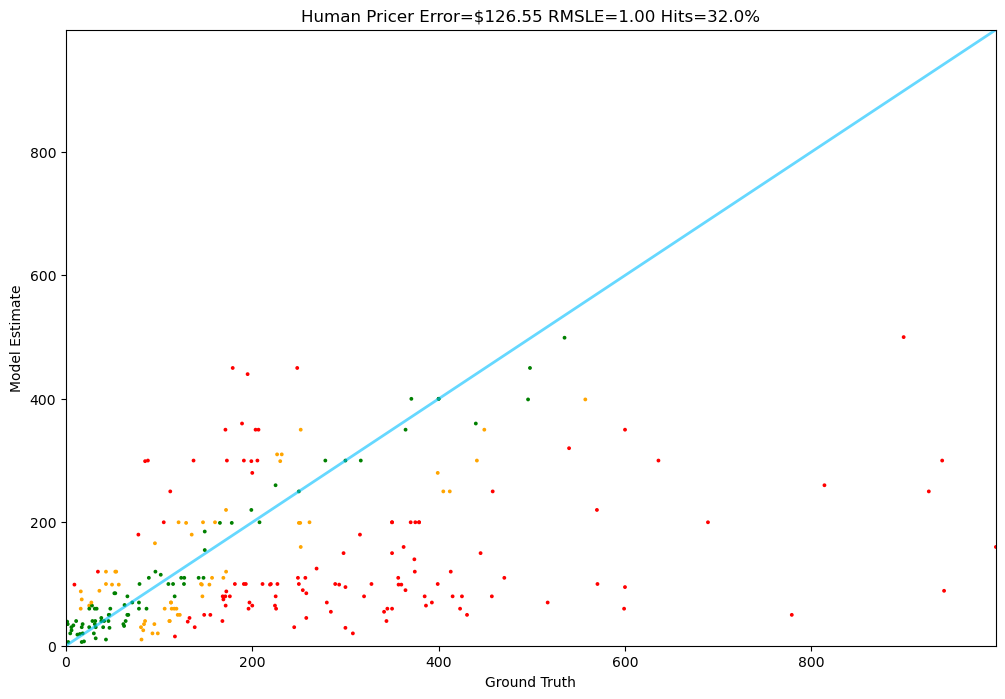

In [11]:
Tester.test(human_pricer, test)

In [12]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [17]:
# a function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [18]:
get_price("The price is roughly $99.99 because blah blah")


99.99

In [21]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [19]:
test[0].price

374.41

1: Guess: $180.00 Truth: $374.41 Error: $194.41 SLE: 0.53 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $599.00 Truth: $289.00 Error: $310.00 SLE: 0.53 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10

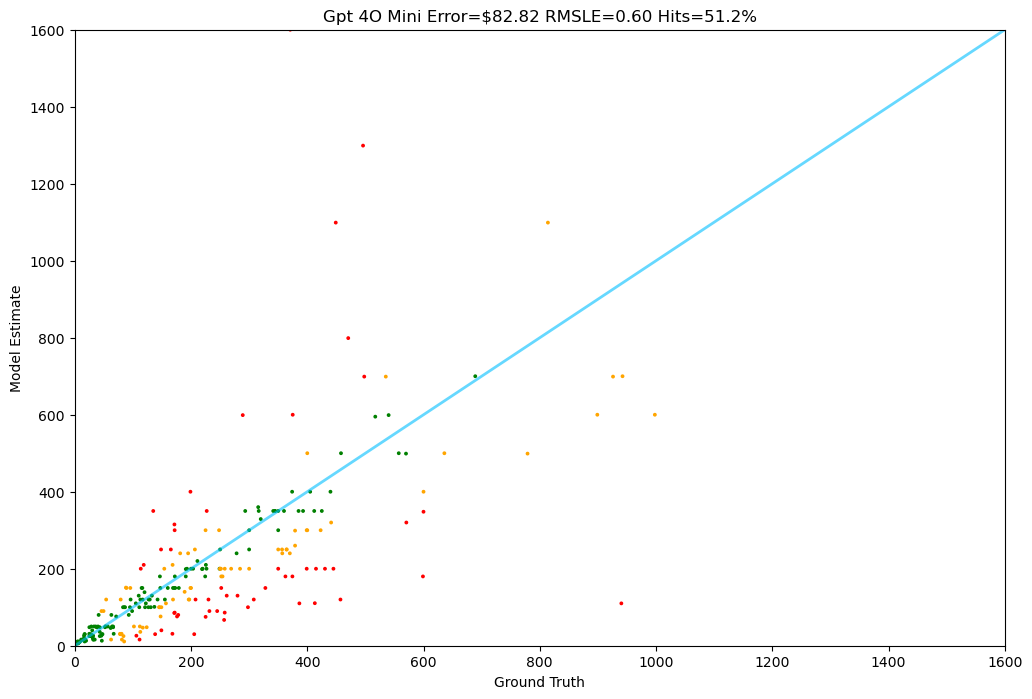

In [24]:
Tester.test(gpt_4o_mini, test)

In [32]:
def gemini(item):
    gemini_via_openai_client = OpenAI(
        api_key=google_api_key, 
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
    
    response = gemini_via_openai_client.chat.completions.create(
        model="gemini-2.0-flash-exp", 
        messages=messages_for(item),
        max_tokens=2000
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
Tester.test(gemini, test)

## Fine Tuning

In [36]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [37]:
fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

In [38]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [39]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...

def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [40]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [65]:

write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [66]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")


In [44]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [45]:
train_file

FileObject(id='file-4Mn5Z8BS6BZfVCFAASNHbn', bytes=470371, created_at=1741258591, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [46]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [47]:
validation_file

FileObject(id='file-GuruGmntyosmBATXC4FQwk', bytes=47059, created_at=1741258623, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [48]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}


In [67]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-i2vBjjzDcct28zjrFycS83N0', created_at=1741260874, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-x9rJegR1mTMebHp2mQshV9N4', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-4Mn5Z8BS6BZfVCFAASNHbn', validation_file='file-GuruGmntyosmBATXC4FQwk', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-i2vBjjzDcct28zjrFycS83N0'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [51]:
openai.fine_tuning.jobs.list(limit=1)


SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-Zi0M0fj4rX72X8f0fhLORjQO', created_at=1741258940, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-x9rJegR1mTMebHp2mQshV9N4', result_files=[], seed=42, status='queued', trained_tokens=None, training_file='file-4Mn5Z8BS6BZfVCFAASNHbn', validation_file='file-GuruGmntyosmBATXC4FQwk', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-Zi0M0fj4rX72X8f0fhLORjQO'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)]

In [52]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id


In [78]:
job_id

'ftjob-Zi0M0fj4rX72X8f0fhLORjQO'

In [79]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-Zi0M0fj4rX72X8f0fhLORjQO', created_at=1741258940, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-x9rJegR1mTMebHp2mQshV9N4', result_files=[], seed=42, status='queued', trained_tokens=None, training_file='file-4Mn5Z8BS6BZfVCFAASNHbn', validation_file='file-GuruGmntyosmBATXC4FQwk', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-Zi0M0fj4rX72X8f0fhLORjQO'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [80]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data


[FineTuningJobEvent(id='ftevent-tllSMpqND7cwvRukKKD0ltDh', created_at=1741259131, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-qGxiSo8LgEUv1A4qlNZ4hRND', created_at=1741258940, level='info', message='Validating training file: file-4Mn5Z8BS6BZfVCFAASNHbn and validation file: file-GuruGmntyosmBATXC4FQwk', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-AEC4l2OrbqjStUW5BQCl1RaH', created_at=1741258940, level='info', message='Created fine-tuning job: ftjob-Zi0M0fj4rX72X8f0fhLORjQO', object='fine_tuning.job.event', data={}, type='message')]

In [83]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).model

print(fine_tuned_model_name)


gpt-4o-mini-2024-07-18


In [69]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [70]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [71]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [72]:
get_price("The price is roughly $99.99 because blah blah")


99.99

In [73]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [84]:
print(test[0].price)

print(gpt_fine_tuned(test[0]))



374.41
180.0


1: Guess: $260.00 Truth: $374.41 Error: $114.41 SLE: 0.13 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $599.00 Truth: $289.00 Error: $310.00 SLE: 0.53 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10

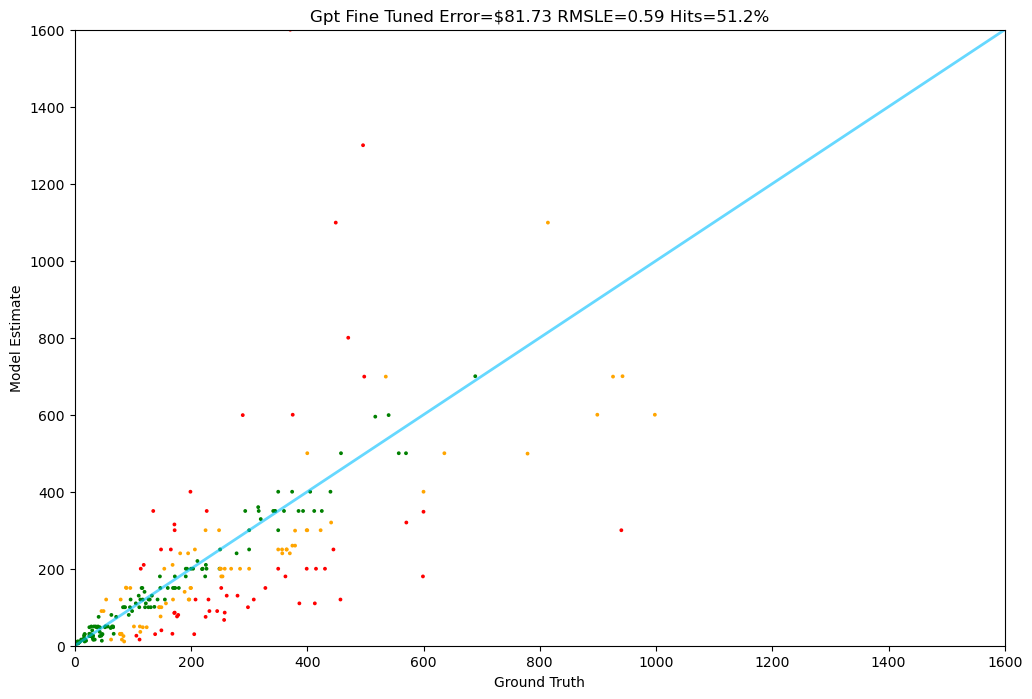

In [85]:
Tester.test(gpt_fine_tuned, test)
